In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
# Set seed
seed = 1453

# https://www.gymlibrary.ml/environments/box2d/lunar_lander/
env = gym.make('LunarLander-v2',
              continuous=True)

# env = gym.make(
#     "LunarLander-v2",
#     continuous=False,
#     gravity=-10.0,
#     enable_wind=False,
#     wind_power=15.0,
#     turbulence_power=1.5,
# )

# This is needed to get the input size for the NN
num_states = env.observation_space.low.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

# Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

# This is needed to clip the actions within the legal boundaries
upper_bound = action_space.high[0]
lower_bound = action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
def get_actor(layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    # Must have output size of 2
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    # Also requires output size of 2 here
    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
class Agent:
    def __init__(self, buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(layer1=400, layer2=300)
        self.critic_model = get_critic(layer1=400, layer2=300)

        self.target_actor = get_actor(layer1=400, layer2=300)
        self.target_critic = get_critic(layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def policy(self, state, noise_object, use_noise=True, noise_mult=1):
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise * noise_mult

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]

In [6]:
def fixed(x, episode):
    return x

In [40]:
def run(total_trials=3, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002, render=False,
            actor_lr=0.001, gamma=0.99, tau=0.005, noise_mult=1, save_weights=False, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=40, output=True,
            return_rewards=False):
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(buffer_capacity=buffer_capacity, batch_size=batch_size, std_dev=std_dev, 
                critic_lr=critic_lr, actor_lr=actor_lr, gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                action = agent.policy(tf_prev_state, agent.ou_noise, noise_mult=noise_mult)
                
                # To get the right format
                action = action[0]
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Eventual reward modification goes here

                agent.record((prev_state, action, reward, state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Episode {} * Avg Reward {:.2f} * true_avg_reward {:.2f} * reward {:.2f} * time used: {:.2f}"
                  .format(ep, avg_reward, true_avg_reward, true_reward, (time.time() - before)))
            avg_reward_list[trial].append(avg_reward)

        if save_weights:
            agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '.h5')
            agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '.h5')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.show()
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [32]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False):
    rewards = []
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(buffer_capacity=0, batch_size=0, std_dev=0, 
                critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(tf_prev_state, 0, use_noise=False)
            action = action[0]
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [33]:
def random(total_episodes=10, render=False):
    rewards = []
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = action_space.sample()
            
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [34]:
def a(x, episode):
    if episode < 100:
        return 5
    elif episode < 200:
        return 3
    elif episode < 300:
        return 2
    elif episode < 400:
        return 1
    else:
        return 0.5

<function matplotlib.pyplot.show(close=None, block=None)>

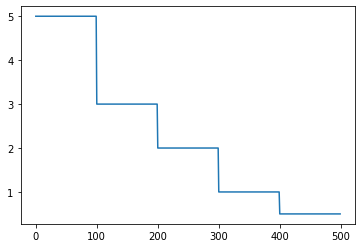

In [29]:
x = 0.2
values = []
for ep in range(500):
    values.append(a(x, ep))
plt.plot(values)
plt.show

Episode * 0 * Avg Reward is ==> -446.3450936389958 * true_avg_reward: -446.3450936389958 * time used: 1.0919454097747803
Episode * 1 * Avg Reward is ==> -460.78418658426597 * true_avg_reward: -460.78418658426597 * time used: 0.564598560333252
Episode * 2 * Avg Reward is ==> -446.912663281385 * true_avg_reward: -446.912663281385 * time used: 0.4017183780670166
Episode * 3 * Avg Reward is ==> -493.9408363518795 * true_avg_reward: -493.9408363518795 * time used: 0.559546709060669
Episode * 4 * Avg Reward is ==> -488.51100167563544 * true_avg_reward: -488.51100167563544 * time used: 0.41678881645202637
Episode * 5 * Avg Reward is ==> -485.86428243332483 * true_avg_reward: -485.86428243332483 * time used: 0.42343640327453613
Episode * 6 * Avg Reward is ==> -485.8612611710196 * true_avg_reward: -485.8612611710196 * time used: 0.46319103240966797
Episode * 7 * Avg Reward is ==> -487.5017589073507 * true_avg_reward: -487.5017589073507 * time used: 0.43643784523010254
Episode * 8 * Avg Reward i

Episode * 67 * Avg Reward is ==> -313.44882611501407 * true_avg_reward: -313.44882611501407 * time used: 0.8116517066955566
Episode * 68 * Avg Reward is ==> -309.24891601778006 * true_avg_reward: -309.24891601778006 * time used: 2.2578320503234863
Episode * 69 * Avg Reward is ==> -313.47982385312685 * true_avg_reward: -313.47982385312685 * time used: 6.586058616638184
Episode * 70 * Avg Reward is ==> -324.7021632960103 * true_avg_reward: -324.7021632960103 * time used: 2.058711051940918
Episode * 71 * Avg Reward is ==> -339.2585823497251 * true_avg_reward: -339.2585823497251 * time used: 2.1407570838928223
Episode * 72 * Avg Reward is ==> -337.0376234402391 * true_avg_reward: -337.0376234402391 * time used: 11.111771821975708
Episode * 73 * Avg Reward is ==> -322.0990361808652 * true_avg_reward: -322.0990361808652 * time used: 0.9552607536315918
Episode * 74 * Avg Reward is ==> -304.59524454835736 * true_avg_reward: -304.59524454835736 * time used: 11.22526240348816
Episode * 75 * Avg 

Episode * 134 * Avg Reward is ==> -104.35022132288559 * true_avg_reward: -104.35022132288559 * time used: 1.9492731094360352
Episode * 135 * Avg Reward is ==> -105.41859099508511 * true_avg_reward: -105.41859099508511 * time used: 1.5380816459655762
Episode * 136 * Avg Reward is ==> -117.48643652546498 * true_avg_reward: -117.48643652546498 * time used: 10.170073509216309
Episode * 137 * Avg Reward is ==> -120.01936496553829 * true_avg_reward: -120.01936496553829 * time used: 2.4714226722717285
Episode * 138 * Avg Reward is ==> -120.71689490305683 * true_avg_reward: -120.71689490305683 * time used: 10.386650085449219
Episode * 139 * Avg Reward is ==> -128.9614023465135 * true_avg_reward: -128.9614023465135 * time used: 1.0469799041748047
Episode * 140 * Avg Reward is ==> -122.55302099007986 * true_avg_reward: -122.55302099007986 * time used: 10.436132907867432
Episode * 141 * Avg Reward is ==> -129.00929793755867 * true_avg_reward: -129.00929793755867 * time used: 0.7996559143066406
Ep

Episode * 201 * Avg Reward is ==> -109.14580121222824 * true_avg_reward: -109.14580121222824 * time used: 2.526853561401367
Episode * 202 * Avg Reward is ==> -110.3721487888397 * true_avg_reward: -110.3721487888397 * time used: 2.5923373699188232
Episode * 203 * Avg Reward is ==> -107.7744341522227 * true_avg_reward: -107.7744341522227 * time used: 11.163389444351196
Episode * 204 * Avg Reward is ==> -106.28127004305672 * true_avg_reward: -106.28127004305672 * time used: 11.800056457519531
Episode * 205 * Avg Reward is ==> -106.4212830171552 * true_avg_reward: -106.4212830171552 * time used: 11.252325296401978
Episode * 206 * Avg Reward is ==> -117.35052696680611 * true_avg_reward: -117.35052696680611 * time used: 5.760660171508789
Episode * 207 * Avg Reward is ==> -125.41355677025868 * true_avg_reward: -125.41355677025868 * time used: 1.2313663959503174
Episode * 208 * Avg Reward is ==> -132.75125644648622 * true_avg_reward: -132.75125644648622 * time used: 1.3743836879730225
Episode 

Episode * 18 * Avg Reward is ==> -405.57618029785516 * true_avg_reward: -405.57618029785516 * time used: 0.7643485069274902
Episode * 19 * Avg Reward is ==> -408.02000999066803 * true_avg_reward: -408.02000999066803 * time used: 0.781280517578125
Episode * 20 * Avg Reward is ==> -394.828924015712 * true_avg_reward: -394.828924015712 * time used: 1.4174354076385498
Episode * 21 * Avg Reward is ==> -396.7989329002725 * true_avg_reward: -396.7989329002725 * time used: 2.0418033599853516
Episode * 22 * Avg Reward is ==> -402.8413661405798 * true_avg_reward: -402.8413661405798 * time used: 1.610074758529663
Episode * 23 * Avg Reward is ==> -417.1997996329936 * true_avg_reward: -417.1997996329936 * time used: 1.2081880569458008
Episode * 24 * Avg Reward is ==> -422.3927140351505 * true_avg_reward: -422.3927140351505 * time used: 0.7249512672424316
Episode * 25 * Avg Reward is ==> -413.3892972863011 * true_avg_reward: -413.3892972863011 * time used: 0.9041757583618164
Episode * 26 * Avg Rewar

Episode * 86 * Avg Reward is ==> -252.92692225007323 * true_avg_reward: -252.92692225007323 * time used: 0.6947154998779297
Episode * 87 * Avg Reward is ==> -249.82200429106496 * true_avg_reward: -249.82200429106496 * time used: 1.670576810836792
Episode * 88 * Avg Reward is ==> -251.05134696631185 * true_avg_reward: -251.05134696631185 * time used: 1.087383508682251
Episode * 89 * Avg Reward is ==> -251.21132839342584 * true_avg_reward: -251.21132839342584 * time used: 0.7182121276855469
Episode * 90 * Avg Reward is ==> -254.12605309725168 * true_avg_reward: -254.12605309725168 * time used: 1.9396724700927734
Episode * 91 * Avg Reward is ==> -256.00304190415284 * true_avg_reward: -256.00304190415284 * time used: 1.130363941192627
Episode * 92 * Avg Reward is ==> -254.21103343514022 * true_avg_reward: -254.21103343514022 * time used: 1.2192859649658203
Episode * 93 * Avg Reward is ==> -256.0721471267833 * true_avg_reward: -256.0721471267833 * time used: 0.8772575855255127
Episode * 94 

Episode * 153 * Avg Reward is ==> -260.8601526955558 * true_avg_reward: -260.8601526955558 * time used: 0.9405808448791504
Episode * 154 * Avg Reward is ==> -251.40259724444013 * true_avg_reward: -251.40259724444013 * time used: 1.1130743026733398
Episode * 155 * Avg Reward is ==> -254.80227978197527 * true_avg_reward: -254.80227978197527 * time used: 1.59832763671875
Episode * 156 * Avg Reward is ==> -249.14543064986475 * true_avg_reward: -249.14543064986475 * time used: 0.6570537090301514
Episode * 157 * Avg Reward is ==> -255.44284899342296 * true_avg_reward: -255.44284899342296 * time used: 0.7113170623779297
Episode * 158 * Avg Reward is ==> -262.04806801225243 * true_avg_reward: -262.04806801225243 * time used: 0.5887041091918945
Episode * 159 * Avg Reward is ==> -259.1380971196066 * true_avg_reward: -259.1380971196066 * time used: 0.5005719661712646
Episode * 160 * Avg Reward is ==> -260.6885891769075 * true_avg_reward: -260.6885891769075 * time used: 0.8128542900085449
Episode 

Episode * 220 * Avg Reward is ==> -287.7970653701033 * true_avg_reward: -287.7970653701033 * time used: 0.8986752033233643
Episode * 221 * Avg Reward is ==> -288.9036761207316 * true_avg_reward: -288.9036761207316 * time used: 0.7531840801239014
Episode * 222 * Avg Reward is ==> -288.3741704165816 * true_avg_reward: -288.3741704165816 * time used: 0.961669921875
Episode * 223 * Avg Reward is ==> -286.1933099991079 * true_avg_reward: -286.1933099991079 * time used: 1.0457673072814941
Episode * 224 * Avg Reward is ==> -278.6221955117361 * true_avg_reward: -278.6221955117361 * time used: 0.9408242702484131
Episode * 225 * Avg Reward is ==> -281.4570735577725 * true_avg_reward: -281.4570735577725 * time used: 0.8432655334472656
Episode * 226 * Avg Reward is ==> -285.0482333881905 * true_avg_reward: -285.0482333881905 * time used: 0.8017454147338867
Episode * 227 * Avg Reward is ==> -282.1763096325197 * true_avg_reward: -282.1763096325197 * time used: 0.8868520259857178
Episode * 228 * Avg 

Episode * 37 * Avg Reward is ==> -231.16529122404953 * true_avg_reward: -231.16529122404953 * time used: 0.5898559093475342
Episode * 38 * Avg Reward is ==> -225.94188020897892 * true_avg_reward: -225.94188020897892 * time used: 0.9808022975921631
Episode * 39 * Avg Reward is ==> -228.8254695853896 * true_avg_reward: -228.8254695853896 * time used: 0.7009425163269043
Episode * 40 * Avg Reward is ==> -218.4787152459904 * true_avg_reward: -218.4787152459904 * time used: 0.5438120365142822
Episode * 41 * Avg Reward is ==> -207.80458079363262 * true_avg_reward: -207.80458079363262 * time used: 0.7803421020507812
Episode * 42 * Avg Reward is ==> -209.70629002378323 * true_avg_reward: -209.70629002378323 * time used: 0.6217763423919678
Episode * 43 * Avg Reward is ==> -214.48929803260944 * true_avg_reward: -214.48929803260944 * time used: 0.516575813293457
Episode * 44 * Avg Reward is ==> -219.84985769628298 * true_avg_reward: -219.84985769628298 * time used: 0.559180736541748
Episode * 45 *

Episode * 104 * Avg Reward is ==> -140.07016898227837 * true_avg_reward: -140.07016898227837 * time used: 1.2555077075958252
Episode * 105 * Avg Reward is ==> -148.05507578543134 * true_avg_reward: -148.05507578543134 * time used: 2.795952081680298
Episode * 106 * Avg Reward is ==> -155.89554774903218 * true_avg_reward: -155.89554774903218 * time used: 3.886230945587158
Episode * 107 * Avg Reward is ==> -156.50963619841187 * true_avg_reward: -156.50963619841187 * time used: 0.82326340675354
Episode * 108 * Avg Reward is ==> -156.7972110512507 * true_avg_reward: -156.7972110512507 * time used: 1.1971361637115479
Episode * 109 * Avg Reward is ==> -155.19403113370657 * true_avg_reward: -155.19403113370657 * time used: 2.2070043087005615
Episode * 110 * Avg Reward is ==> -154.40602247442885 * true_avg_reward: -154.40602247442885 * time used: 1.0641672611236572
Episode * 111 * Avg Reward is ==> -156.8717346914635 * true_avg_reward: -156.8717346914635 * time used: 1.18888258934021
Episode * 

Episode * 171 * Avg Reward is ==> -329.2653964174409 * true_avg_reward: -329.2653964174409 * time used: 1.517960786819458
Episode * 172 * Avg Reward is ==> -337.8481046736776 * true_avg_reward: -337.8481046736776 * time used: 1.232116937637329
Episode * 173 * Avg Reward is ==> -344.6617216229961 * true_avg_reward: -344.6617216229961 * time used: 1.0471374988555908
Episode * 174 * Avg Reward is ==> -350.84003835656114 * true_avg_reward: -350.84003835656114 * time used: 1.0685060024261475
Episode * 175 * Avg Reward is ==> -349.4318348039018 * true_avg_reward: -349.4318348039018 * time used: 0.978492259979248
Episode * 176 * Avg Reward is ==> -346.9956855544452 * true_avg_reward: -346.9956855544452 * time used: 1.2506239414215088
Episode * 177 * Avg Reward is ==> -345.8803106717249 * true_avg_reward: -345.8803106717249 * time used: 1.2416527271270752
Episode * 178 * Avg Reward is ==> -346.76959817640943 * true_avg_reward: -346.76959817640943 * time used: 0.7113540172576904
Episode * 179 *

Episode * 238 * Avg Reward is ==> -180.28768987620245 * true_avg_reward: -180.28768987620245 * time used: 2.4029576778411865
Episode * 239 * Avg Reward is ==> -181.56700197329434 * true_avg_reward: -181.56700197329434 * time used: 1.803405523300171
Episode * 240 * Avg Reward is ==> -183.32390638741686 * true_avg_reward: -183.32390638741686 * time used: 2.1129796504974365
Episode * 241 * Avg Reward is ==> -179.7984808711467 * true_avg_reward: -179.7984808711467 * time used: 2.3708834648132324
Episode * 242 * Avg Reward is ==> -183.42604214710371 * true_avg_reward: -183.42604214710371 * time used: 1.5119307041168213
Episode * 243 * Avg Reward is ==> -183.5355480363392 * true_avg_reward: -183.5355480363392 * time used: 1.1181671619415283
Episode * 244 * Avg Reward is ==> -180.37505728569477 * true_avg_reward: -180.37505728569477 * time used: 0.6923379898071289
Episode * 245 * Avg Reward is ==> -172.23133037714607 * true_avg_reward: -172.23133037714607 * time used: 0.788240909576416
Episod

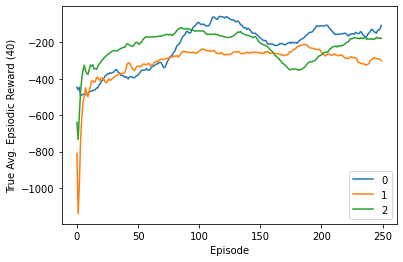

In [23]:
run(total_trials=3, total_episodes=250, noise_mult_func=a, save_weights=True)

In [ ]:
run(total_trials=3, total_episodes=500, noise_mult_func=a, save_weights=True)

Episode 0 * Avg Reward -261.35 * true_avg_reward -261.35 * reward -261.35 * time used: 1.69
Episode 1 * Avg Reward -200.09 * true_avg_reward -200.09 * reward -138.82 * time used: 1.14
Episode 2 * Avg Reward -173.40 * true_avg_reward -173.40 * reward -120.02 * time used: 0.98
Episode 3 * Avg Reward -164.59 * true_avg_reward -164.59 * reward -138.17 * time used: 0.79
Episode 4 * Avg Reward -162.51 * true_avg_reward -162.51 * reward -154.21 * time used: 0.92
Episode 5 * Avg Reward -173.22 * true_avg_reward -173.22 * reward -226.76 * time used: 0.86
Episode 6 * Avg Reward -198.62 * true_avg_reward -198.62 * reward -351.00 * time used: 0.71
Episode 7 * Avg Reward -191.48 * true_avg_reward -191.48 * reward -141.54 * time used: 1.03
Episode 8 * Avg Reward -204.46 * true_avg_reward -204.46 * reward -308.24 * time used: 0.93
Episode 9 * Avg Reward -235.03 * true_avg_reward -235.03 * reward -510.22 * time used: 1.04
Episode 10 * Avg Reward -225.16 * true_avg_reward -225.16 * reward -126.40 * tim

Episode 89 * Avg Reward -234.71 * true_avg_reward -234.71 * reward -339.14 * time used: 1.36
Episode 90 * Avg Reward -235.24 * true_avg_reward -235.24 * reward -348.82 * time used: 1.09
Episode 91 * Avg Reward -240.03 * true_avg_reward -240.03 * reward -283.17 * time used: 0.96
Episode 92 * Avg Reward -243.76 * true_avg_reward -243.76 * reward -208.04 * time used: 0.86
Episode 93 * Avg Reward -244.85 * true_avg_reward -244.85 * reward -252.71 * time used: 0.78
Episode 94 * Avg Reward -245.89 * true_avg_reward -245.89 * reward -463.38 * time used: 1.26
Episode 95 * Avg Reward -249.47 * true_avg_reward -249.47 * reward -279.37 * time used: 0.76
Episode 96 * Avg Reward -263.42 * true_avg_reward -263.42 * reward -668.21 * time used: 1.35
Episode 97 * Avg Reward -268.07 * true_avg_reward -268.07 * reward -436.24 * time used: 0.85
Episode 98 * Avg Reward -273.11 * true_avg_reward -273.11 * reward -430.90 * time used: 1.04
Episode 99 * Avg Reward -283.98 * true_avg_reward -283.98 * reward -49

6.472491502761841s
5.964925765991211s
4.729428052902222s
4.562860012054443s
5.057069540023804s
9.486961841583252s
5.611126899719238s
2.734872341156006s
5.750250577926636s
20.42548370361328s


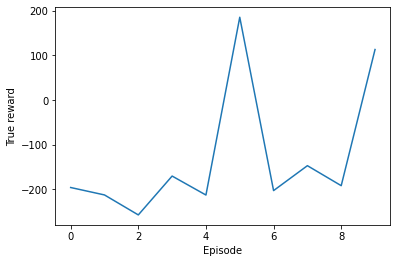

In [24]:
test(render=True)